In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pickle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
Data_path = "/content/gdrive/My Drive/Datasets/Fertilizer_Prediction.csv"

# Exploring the Data

In [5]:
data = pd.read_csv(Data_path)
data.drop('Moisture', inplace=True, axis=1)
data.head()

,Temparature,Humidity,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,Sandy,Maize,37,0,0,Urea
1,29,52,Loamy,Sugarcane,12,0,36,DAP
2,34,65,Black,Cotton,7,9,30,14-35-14
3,32,62,Red,Tobacco,22,0,20,28-28
4,28,54,Clayey,Paddy,35,0,0,Urea


In [6]:
data["Fertilizer Name"].unique()

array(['Urea', 'DAP', '14-35-14', '28-28', '17-17-17', '20-20',
       '10-26-26'], dtype=object)

In [7]:
data.shape

(99, 8)

In [8]:
data["Soil Type"].unique()

array(['Sandy', 'Loamy', 'Black', 'Red', 'Clayey'], dtype=object)

In [9]:
data["Crop Type"].unique()

array(['Maize', 'Sugarcane', 'Cotton', 'Tobacco', 'Paddy', 'Barley',
       'Wheat', 'Millets', 'Oil seeds', 'Pulses', 'Ground Nuts'],
      dtype=object)

In [10]:
data.columns

Index(['Temparature', 'Humidity ', 'Soil Type', 'Crop Type', 'Nitrogen',
       'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')

# Univariant Analysis

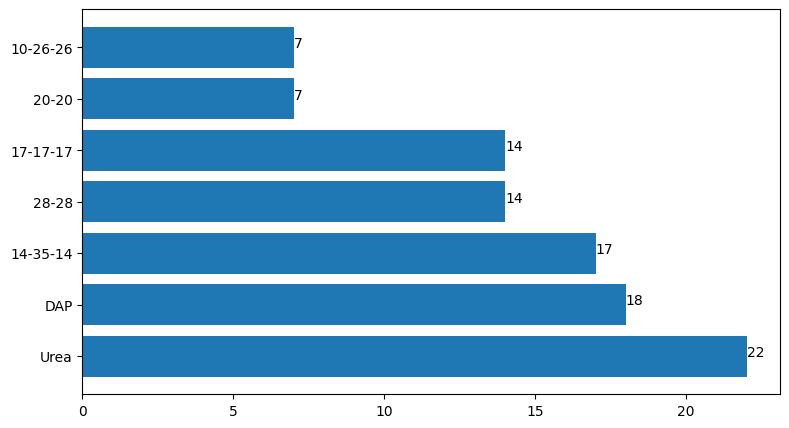

In [11]:
labels = data["Fertilizer Name"].unique()
counts = list(data["Fertilizer Name"].value_counts())

plt.figure(figsize = (9,5))
plt.barh(labels, counts)
  
for index, value in enumerate(counts):
    plt.text(value, index,
             str(value))
plt.show()

**Observation:** We can notice that the above data is not balanced. We will be balancing the data using Upsampling.

In [12]:
continuous_data_cols = ["Temparature", "Humidity ", "Nitrogen", "Phosphorous"]
categorical_data_cols = ["Soil Type", "Crop Type"]

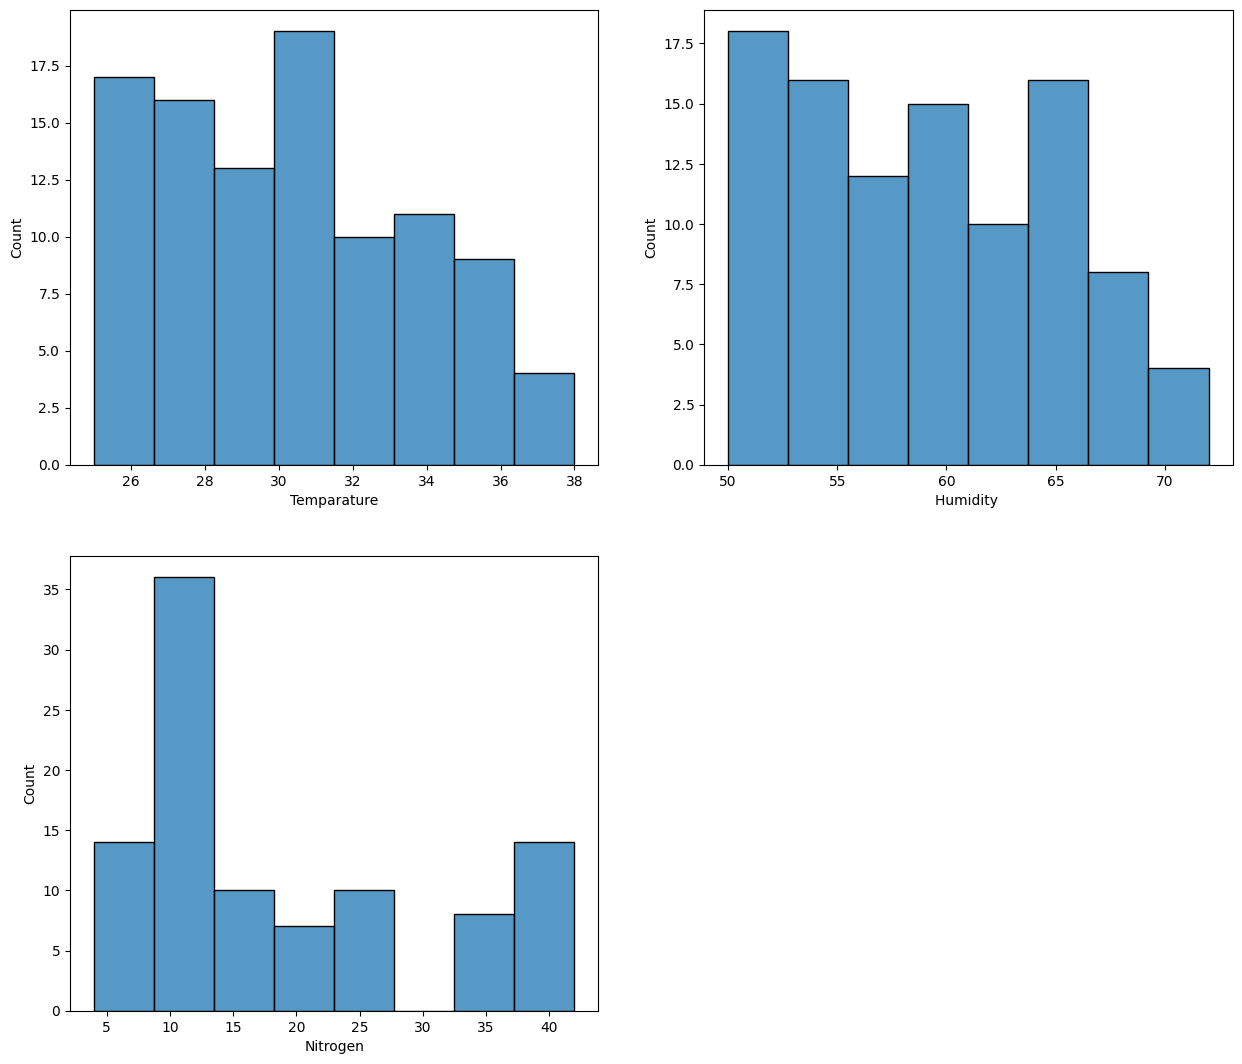

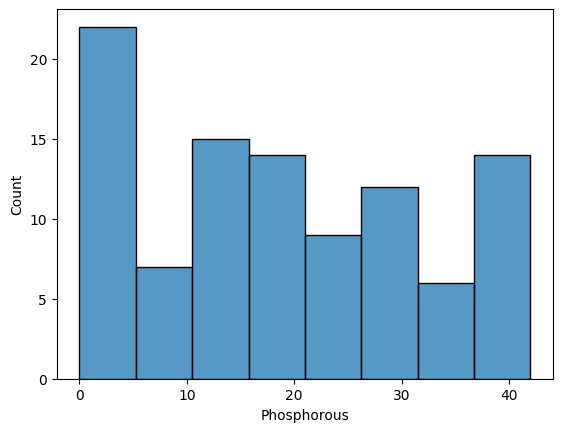

In [13]:
plt.figure(figsize=(15,13))
i = 1
for column in continuous_data_cols[:-1]:
    plt.subplot(2,2,i)
    sns.histplot(data[column])
    i+=1
plt.show()

sns.histplot(data[continuous_data_cols[-1]])
plt.show()

ValueError: ignored

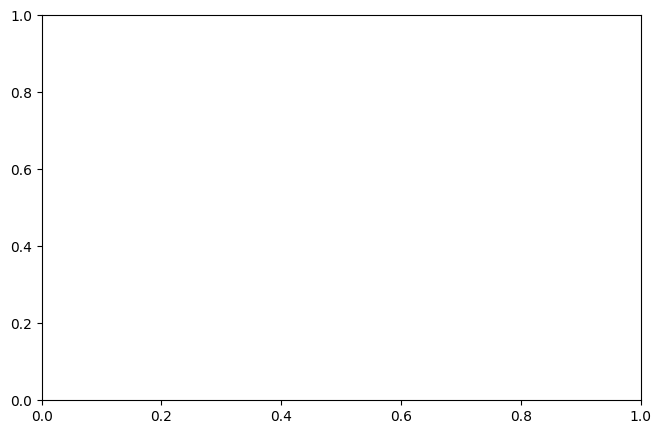

In [16]:
plt.figure(figsize=(17,5))
i = 1
for column in categorical_data_cols:
    plt.subplot(1,2,i)
    sns.countplot(data[column])
    plt.xticks(rotation = 90)
    i+=1
plt.show()

# Bivariate Analysis

<Figure size 2100x1700 with 0 Axes>

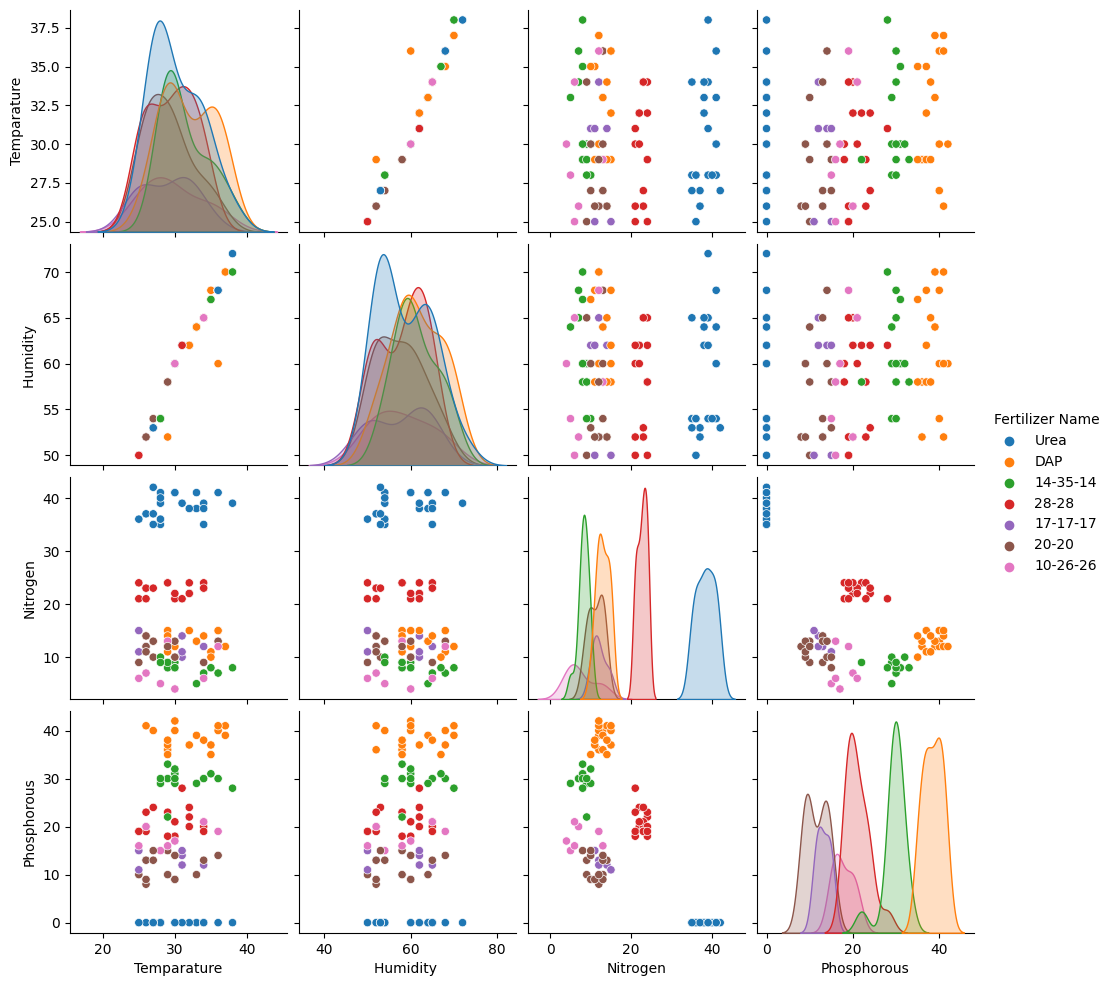

In [14]:
plt.figure(figsize=(21,17))
sns.pairplot(data[continuous_data_cols + ["Fertilizer Name"]], hue = "Fertilizer Name")
plt.show()

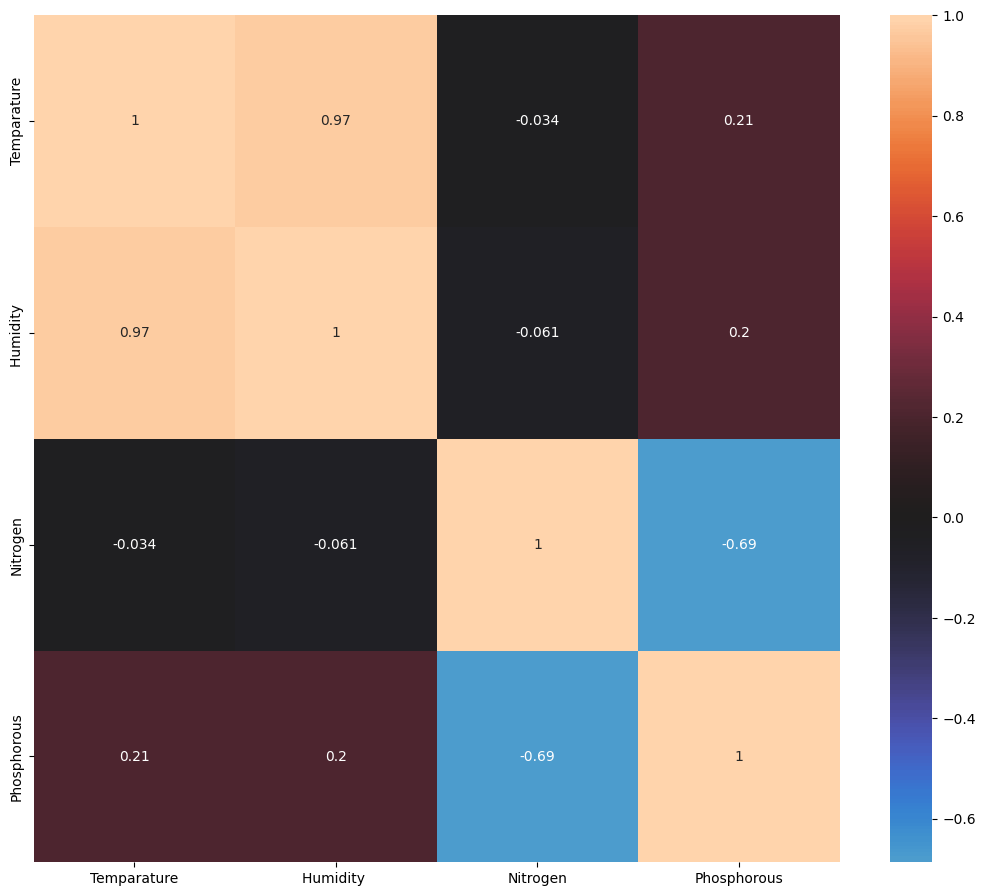

In [15]:
plt.figure(figsize = (13,11))
sns.heatmap(data[continuous_data_cols].corr(), center = 0, annot = True)
plt.show()

In [16]:
soil_type_label_encoder = LabelEncoder()
data["Soil Type"] = soil_type_label_encoder.fit_transform(data["Soil Type"])

In [17]:
crop_type_label_encoder = LabelEncoder()
data["Crop Type"] = crop_type_label_encoder.fit_transform(data["Crop Type"])

In [18]:
croptype_dict = {}
for i in range(len(data["Crop Type"].unique())):
    croptype_dict[i] = crop_type_label_encoder.inverse_transform([i])[0]
print(croptype_dict)

soiltype_dict = {}
for i in range(len(data["Soil Type"].unique())):
    soiltype_dict[i] = soil_type_label_encoder.inverse_transform([i])[0]
print(soiltype_dict)

{0: 'Barley', 1: 'Cotton', 2: 'Ground Nuts', 3: 'Maize', 4: 'Millets', 5: 'Oil seeds', 6: 'Paddy', 7: 'Pulses', 8: 'Sugarcane', 9: 'Tobacco', 10: 'Wheat'}
{0: 'Black', 1: 'Clayey', 2: 'Loamy', 3: 'Red', 4: 'Sandy'}


In [19]:
fertname_label_encoder = LabelEncoder()
data["Fertilizer Name"] = fertname_label_encoder.fit_transform(data["Fertilizer Name"])

In [20]:
fertname_dict = {}
for i in range(len(data["Fertilizer Name"].unique())):
    fertname_dict[i] = fertname_label_encoder.inverse_transform([i])[0]
print(fertname_dict)

{0: '10-26-26', 1: '14-35-14', 2: '17-17-17', 3: '20-20', 4: '28-28', 5: 'DAP', 6: 'Urea'}


In [21]:
data.head()

,Temparature,Humidity,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,4,3,37,0,0,6
1,29,52,2,8,12,0,36,5
2,34,65,0,1,7,9,30,1
3,32,62,3,9,22,0,20,4
4,28,54,1,6,35,0,0,6


In [22]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

# Upsampling the Data

In [23]:
counter = Counter(y)
counter

Counter({6: 22, 5: 18, 1: 14, 4: 17, 2: 7, 3: 14, 0: 7})

In [24]:
upsample = SMOTE()
X, y = upsample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({6: 22, 5: 22, 1: 22, 4: 22, 2: 22, 3: 22, 0: 22})


In [25]:
print(f"Total Data after Upsampling: {len(X)}")

Total Data after Upsampling: 154


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size = 0.2, random_state = 0)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Train Data: {X_test.shape}, {y_test.shape}")

Train Data: (123, 7), (123,)
Train Data: (31, 7), (31,)


# KNN Classifier

Accuracy at k = 1 is 0.9354838709677419
Accuracy at k = 2 is 0.9032258064516129
Accuracy at k = 3 is 0.9354838709677419
Accuracy at k = 4 is 0.9032258064516129
Accuracy at k = 5 is 0.8709677419354839
Accuracy at k = 6 is 0.8387096774193549
Accuracy at k = 7 is 0.8387096774193549
Accuracy at k = 8 is 0.8064516129032258
Accuracy at k = 9 is 0.8387096774193549
Accuracy at k = 10 is 0.8387096774193549
Accuracy at k = 11 is 0.8709677419354839
Accuracy at k = 12 is 0.8387096774193549
Accuracy at k = 13 is 0.9032258064516129
Accuracy at k = 14 is 0.8387096774193549
Accuracy at k = 15 is 0.8387096774193549
Accuracy at k = 16 is 0.8387096774193549
Accuracy at k = 17 is 0.8709677419354839
Accuracy at k = 18 is 0.8387096774193549
Accuracy at k = 19 is 0.9032258064516129
Accuracy at k = 20 is 0.8387096774193549
Accuracy at k = 21 is 0.8709677419354839
Accuracy at k = 22 is 0.8064516129032258
Accuracy at k = 23 is 0.7419354838709677
Accuracy at k = 24 is 0.7419354838709677
Accuracy at k = 25 is 0.7

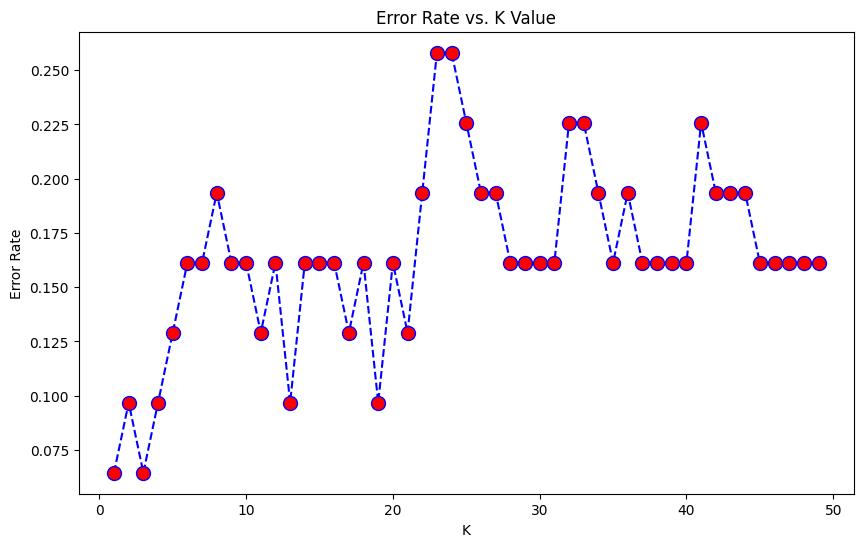

In [27]:
error_rate = []
for i in range(1, 50):
    pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = i))
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy at k = {i} is {accuracy}")
    error_rate.append(np.mean(predictions != y_test)) 
  
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

# SVM Classifier

Accuracy on Test Data: 100.0%


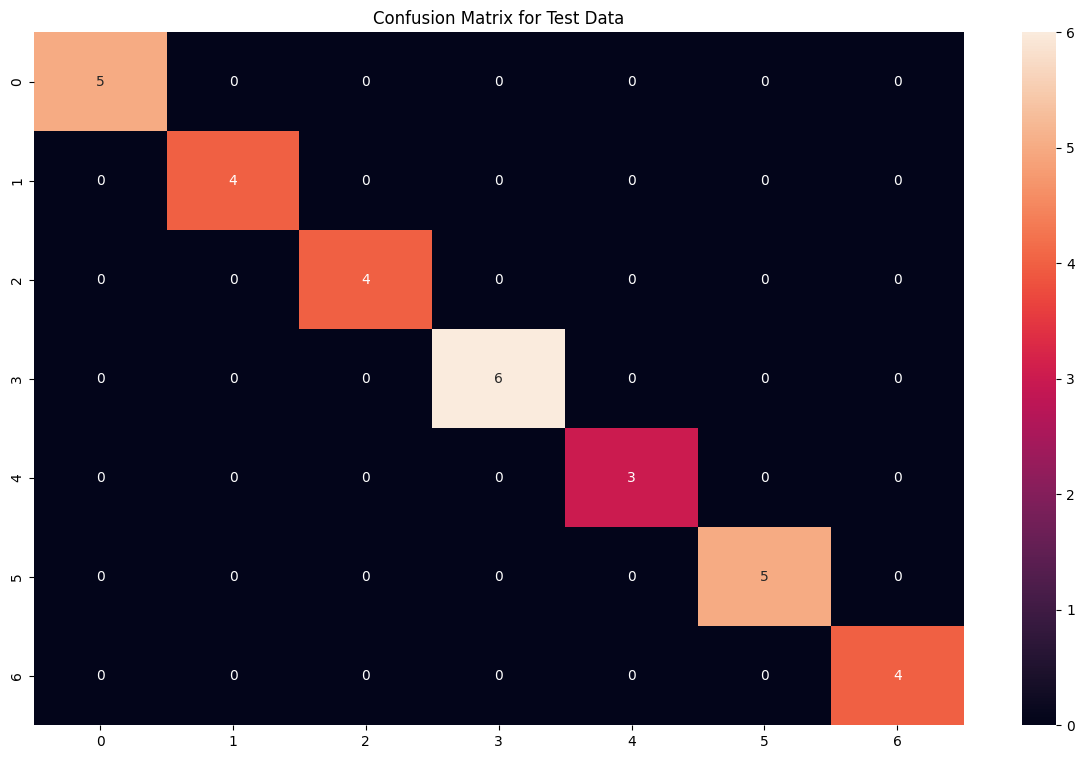


Accuracy on Whole Data: 100.0%


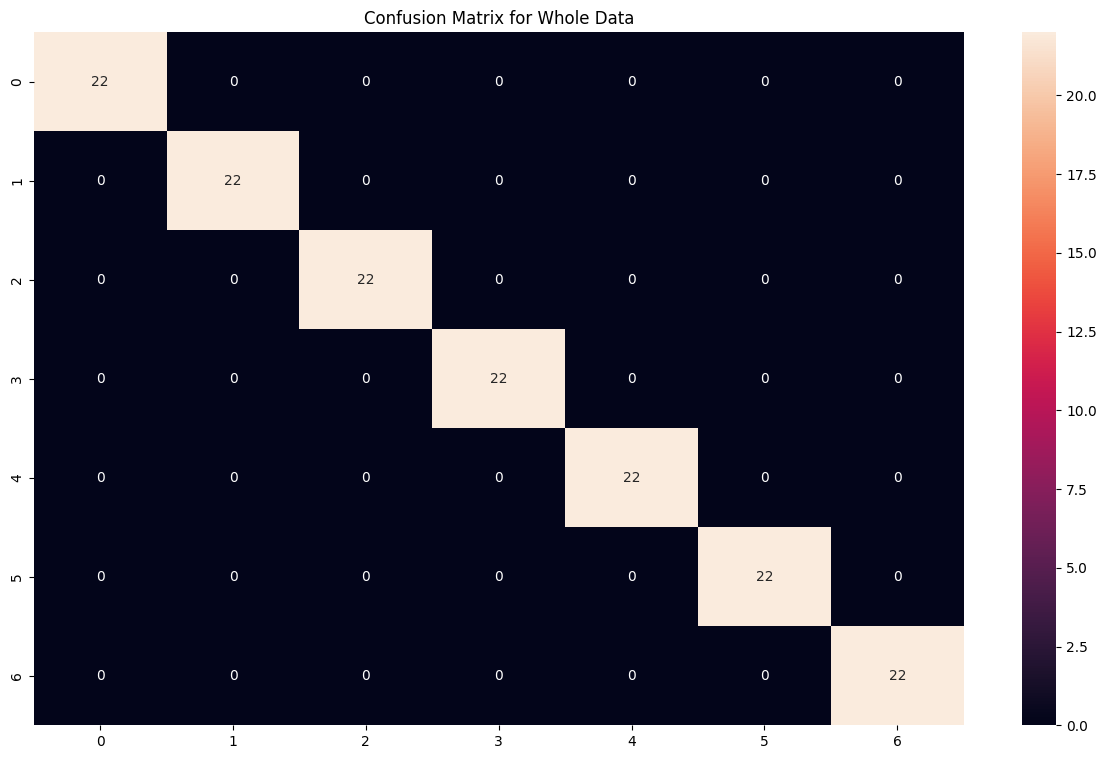

In [28]:
svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True))
svm_pipeline.fit(X_train, y_train)

# Accuray On Test Data
predictions = svm_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on Test Data: {accuracy*100}%")
plt.figure(figsize = (15,9))
sns.heatmap(confusion_matrix(y_test, predictions), annot = True)
plt.title("Confusion Matrix for Test Data")
plt.show()

print()

# Accuray On Whole Data
predictions = svm_pipeline.predict(X.values)
accuracy = accuracy_score(y, predictions)
print(f"Accuracy on Whole Data: {accuracy*100}%")
plt.figure(figsize = (15,9))
sns.heatmap(confusion_matrix(y, predictions), annot = True)
plt.title("Confusion Matrix for Whole Data")
plt.show()


# Random Forest Classifier

Accuracy on Test Data: 100.0%


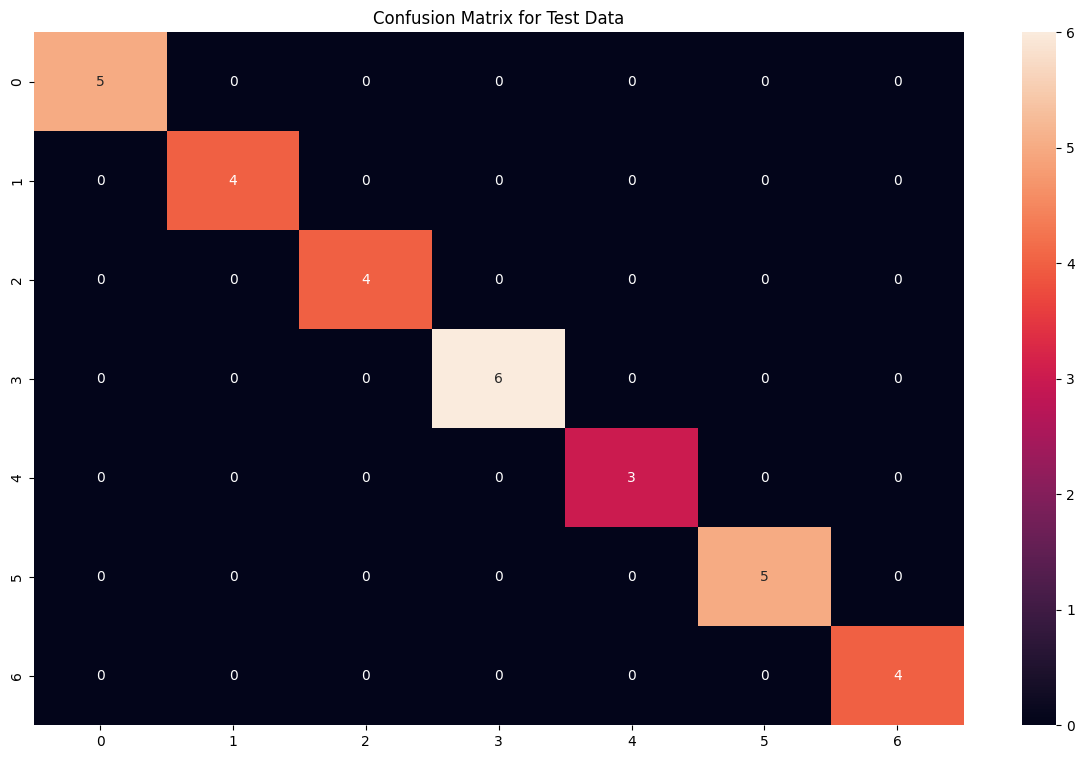


Accuracy on Whole Data: 100.0%


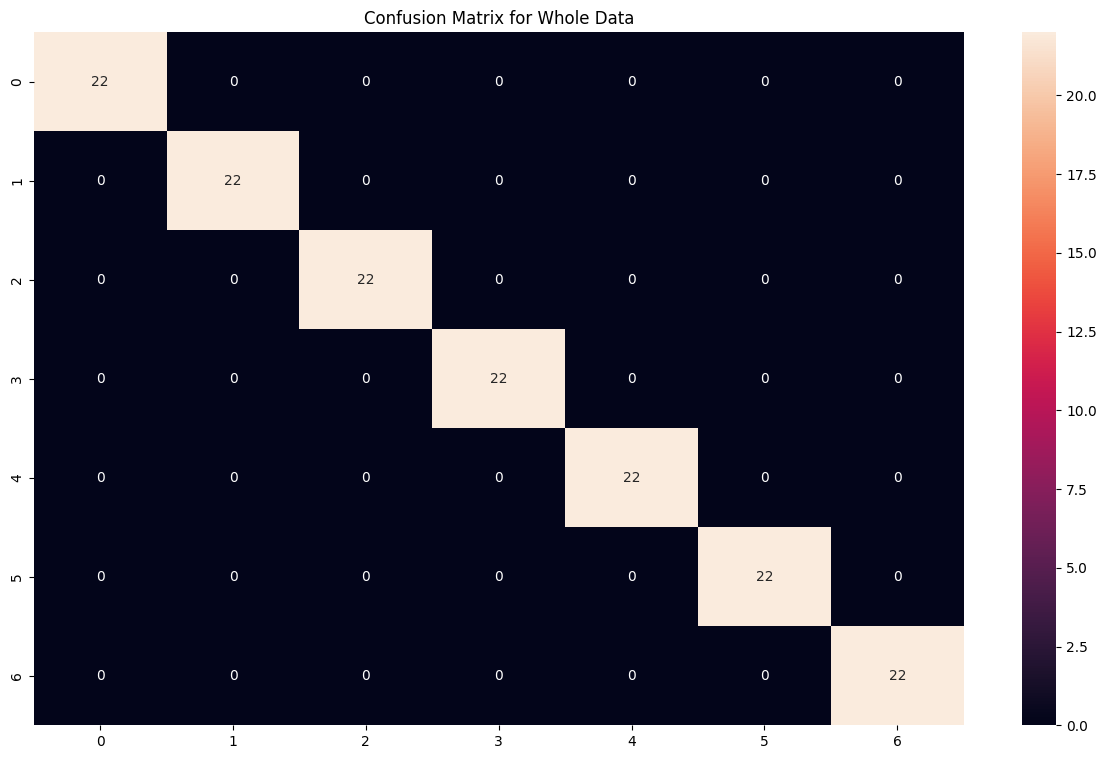

In [29]:
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 18))
rf_pipeline.fit(X_train, y_train)

# Accuray On Test Data
predictions = rf_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on Test Data: {accuracy*100}%")
plt.figure(figsize = (15,9))
sns.heatmap(confusion_matrix(y_test, predictions), annot = True)
plt.title("Confusion Matrix for Test Data")
plt.show()

print()

# Accuray On Whole Data
predictions = rf_pipeline.predict(X.values)
accuracy = accuracy_score(y, predictions)
print(f"Accuracy on Whole Data: {accuracy*100}%")
plt.figure(figsize = (15,9))
sns.heatmap(confusion_matrix(y, predictions), annot = True)
plt.title("Confusion Matrix for Whole Data")
plt.show()

# XGBoost Classifier

Accuracy on Test Data: 100.0%


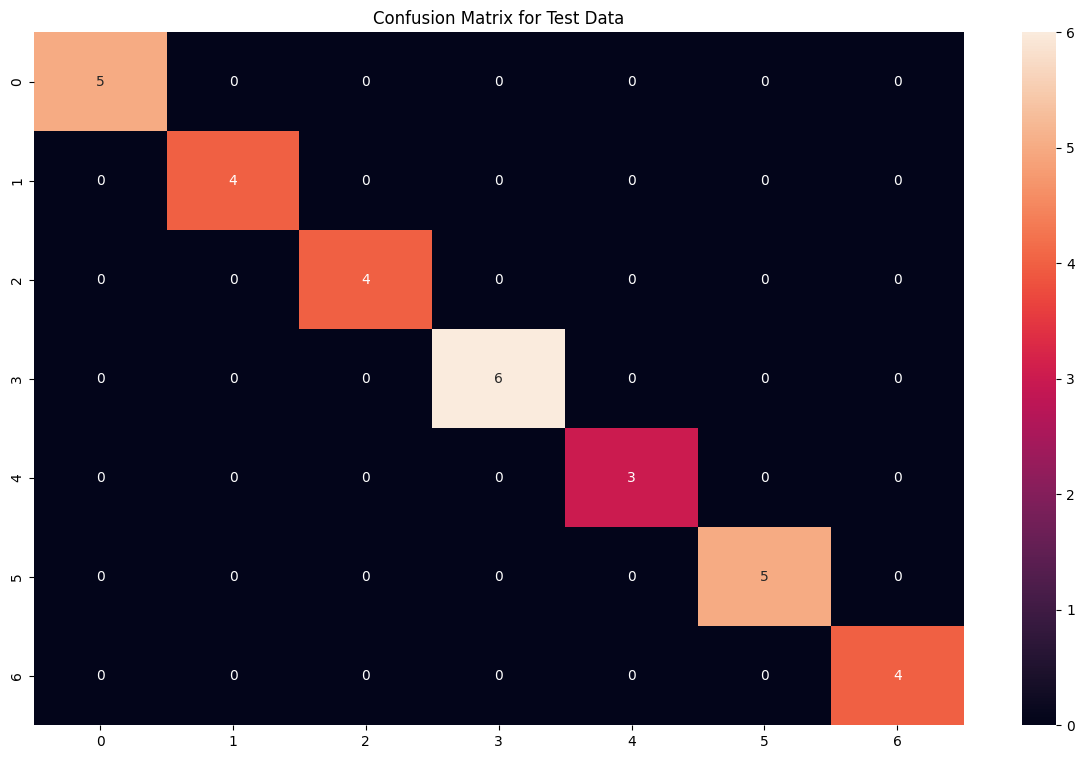

<class 'numpy.ndarray'>
Accuracy on Whole Data: 100.0%


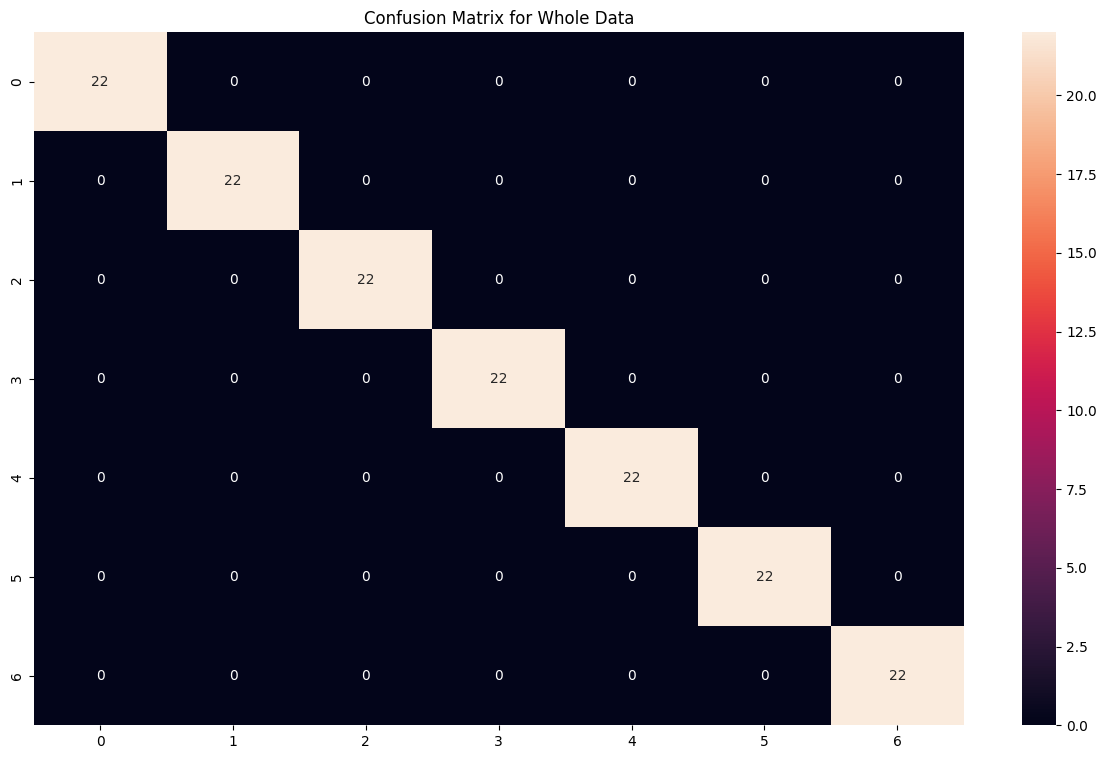

In [30]:
xgb_pipeline = make_pipeline(StandardScaler(), XGBClassifier(random_state = 18))
xgb_pipeline.fit(X_train, y_train)

# Accuray On Test Data
predictions = xgb_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on Test Data: {accuracy*100}%")
plt.figure(figsize = (15,9))
sns.heatmap(confusion_matrix(y_test, predictions), annot = True)
plt.title("Confusion Matrix for Test Data")
plt.show()

print(type(predictions))

# Accuray On Whole Data
predictions = xgb_pipeline.predict(X.values)
accuracy = accuracy_score(y, predictions)
print(f"Accuracy on Whole Data: {accuracy*100}%")
plt.figure(figsize = (15,9))
sns.heatmap(confusion_matrix(y, predictions), annot = True)
plt.title("Confusion Matrix for Whole Data")
plt.show()

In [31]:
pickle.dump(svm_pipeline, open("svm_pipeline.pkl", "wb"))
pickle.dump(rf_pipeline, open("rf_pipeline.pkl", "wb"))
pickle.dump(xgb_pipeline, open("xgb_pipeline.pkl", "wb"))
pickle.dump(fertname_dict, open("fertname_dict.pkl", "wb"))
pickle.dump(croptype_dict, open("croptype_dict.pkl", "wb"))
pickle.dump(soiltype_dict, open("soiltype_dict.pkl", "wb"))
print("Saved All Models")

Saved All Models


Accuracy on Whole Data: 100.0%


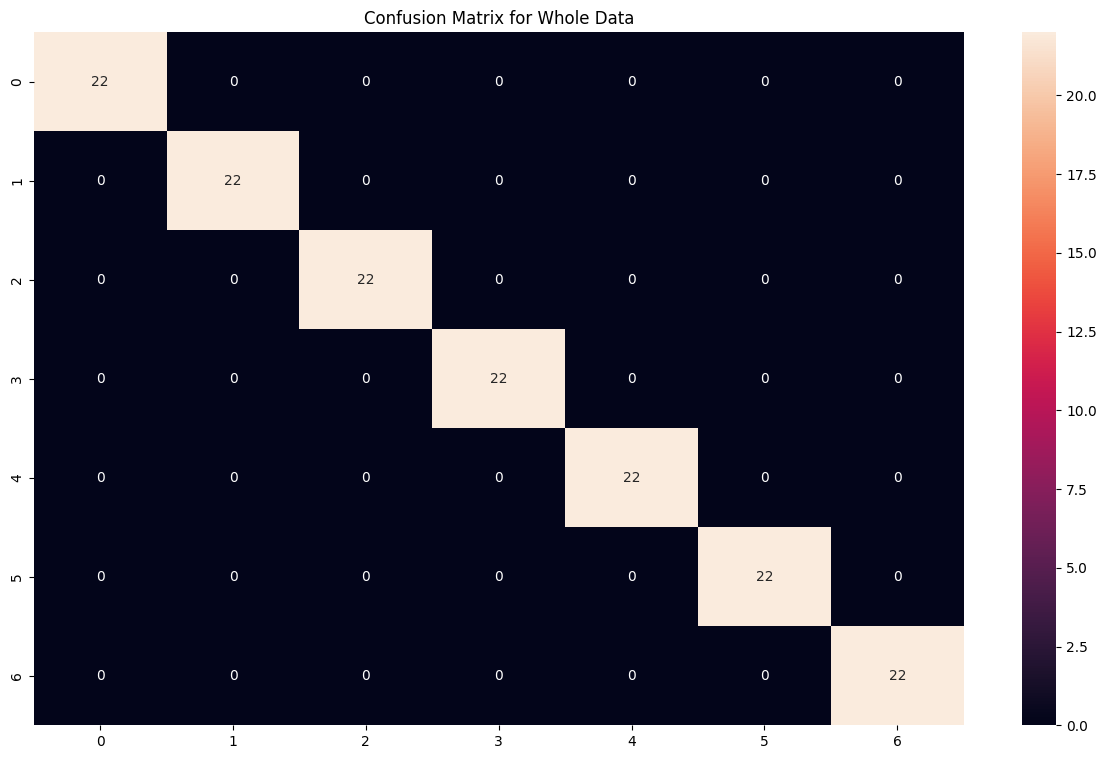

the accuracy by combining these models together is: 100.0%


In [32]:
from scipy import stats

def fertilizer_prediction(input_data):
    prediction_data = {
        "xgb_model_prediction":
            xgb_pipeline.predict(input_data)[0]
        ,
        "xgb_model_probability": max(
            xgb_pipeline.predict_proba(input_data)[0]
        )
        * 100,
        "rf_model_prediction": 
            rf_pipeline.predict(input_data)[0]
        ,
        "rf_model_probability": max(rf_pipeline.predict_proba(input_data)[0])
        * 100,
        "svm_model_prediction": 
            svm_pipeline.predict(input_data)[0]
        ,
        "svm_model_probability": max(
            svm_pipeline.predict_proba(input_data)[0]
        )
        * 100,
    }

    all_predictions = [
            prediction_data["xgb_model_prediction"],
            prediction_data["rf_model_prediction"],
            prediction_data["svm_model_prediction"],
        ]

    all_probs = [
            prediction_data["xgb_model_probability"],
            prediction_data["rf_model_probability"],
            prediction_data["svm_model_probability"],
        ]

    if len(set(all_predictions)) == len(all_predictions):
        prediction_data["final_prediction"] = all_predictions[all_probs.index(max(all_probs))]
    else:
        prediction_data["final_prediction"] = stats.mode(all_predictions)[0][0]

    return prediction_data["final_prediction"]

predictions_final= []
for input in X.itertuples():
  input_data = np.asarray(input[1:]).reshape(1,-1)
  predictions_final.append(fertilizer_prediction(input_data))
predict = np.array(predictions_final)
#print(predict)
acc = accuracy_score(y, predict)
print(f"Accuracy on Whole Data: {acc*100}%")
plt.figure(figsize = (15,9))
sns.heatmap(confusion_matrix(y, predict), annot = True)
plt.title("Confusion Matrix for Whole Data")
plt.show()
print(f"the accuracy by combining these models together is: {acc*100}%")